# Support Vector Machines and Neural Networks
We strongly recommend consulting the related exercises' jupyter notebooks and the referenced URLs when working on this task.

In [99]:
# set random seeds
import random

import matplotlib.pyplot as plt
import numpy as np
# Import Pandas and NumPy functionality for editing data
import pandas as pd
import seaborn as sns
# Importing IPython display for visualizing intermediate results in the notebook
from IPython.display import display
import itertools as it

# data preparation
# classifiers
# evaluation

random.seed(42)
np.random.seed(42)


In [100]:
# general variables that may help you in the tasks
numeric_features = ["age", "trestbps", "chol", "thalch", "oldpeak"]
colors_target = {"healthy heart": "b", "heart condition": "r", 0: "b", 1: "r", 2: "g", 3: "y", 4: "m"}
markers_target = {"healthy heart": "o", "heart condition": "^", 2: "d", 3: "s", 4: "v", 0: "o", 1: "^", }
colors = ["blue", "red", "green", "yellow", "cyan"]
markers = ["o", "^", "d", "s", "v"]

### we recommend creating two datasets for the SVM and NN classifiers both with a column called "target" containing the target values. This allows you to make use of the following functions for both classifiers. You don"t need to use these functions, but they might appear useful to you.
### for the full data you use on the neural network, we recommend just renaming the column called "num" (df.rename(columns={"num": "target"}) 
### in the binary classifiers this target column should contain the values "healthy heart" and "heart condition" 
target_name = "target"
target = [target_name]

In [101]:
###### Potentially useful functions ######

# Pairplot for numeric features
def create_pairplot(data: pd.DataFrame, features: list = numeric_features, target_name: str = target_name,
                    markers: list = markers, name: str = None):
    markers = markers[:len(data[target_name].unique())]
    pairplot = sns.pairplot(data[features + [target_name]], hue=target_name, diag_kind="hist", markers=markers)
    if name:
        pairplot.fig.suptitle(f"Pairplot for {name}")
        pairplot.savefig(f"pairplot_{name}.png")

    display(pairplot)


# Bar Chart for values in selected column
def create_barchart_selected_column(training_data: pd.DataFrame, test_data: pd.DataFrame, column_name: str,
                                    name: str = None, relative_values: bool = True):
    for data_name, data in zip(('Training Data', 'Test Data'), (training_data, test_data)):

        class_counts = data[column_name].value_counts(normalize=relative_values)
        class_counts = class_counts.round(2)

        ax = class_counts.plot(kind="bar")

        for p in ax.patches:
            ax.annotate(f"{p.get_height()}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha="center", va="center",
                        xytext=(0, 10),
                        textcoords="offset points")

        plt.xlabel(column_name)
        plt.ylabel("Frequency")
        plt.title(f"Frequency of Instances per {column_name} in  {data_name}")

        # make xaxis labels horizontal
        plt.xticks(rotation=0)

        plt.tight_layout()
        if name:
            plt.savefig(f"hist_{name}_{data_name}.png")
        else:
            plt.savefig(f"hist_{data_name}.png")
        plt.show()


## Create 3D scatter plot
def create_3d_scatter(data: pd.DataFrame, x_column: str, y_column: str, z_column: str, target_name: str = target_name,
                      colors: dict = colors_target, markers: dict = markers_target, name: str = None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the 3D scatter plot with different colors and markers
    for target_class in data[target_name].unique():
        class_data = data[data[target_name] == target_class]
        ax.scatter(class_data[x_column], class_data[y_column], class_data[z_column],
                   c=colors[target_class], marker=markers[target_class], label=target_class)

    # Set labels
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_zlabel(z_column)

    # Set title
    ax.set_title(f"3D Scatter Plot: {x_column}, {y_column}, {z_column}")

    if name:
        plt.savefig(f"3d_scatter_{name}_{x_column}_{y_column}_{z_column}.png")

    # Show plot
    plt.show()


## results grid search
def compare_results_grid_search(grid_object, run_name: str):
    results = pd.DataFrame(grid_object.cv_results_)

    plt.figure(figsize=(10, 8))

    colors_setting = {"linear": "r", "rbf": "y", "sigmoid": "g", "poly": "b"}
    markers_setting = {"linear": "o", "rbf": "^", "sigmoid": "s", "poly": "x"}

    for kernel in results["param_kernel"].unique():
        kernel_data = results[results["param_kernel"] == kernel]
        plt.scatter(kernel_data["param_C"], kernel_data["mean_test_score"],
                    label=kernel, marker=markers_setting[kernel], color=colors_setting[kernel])

    plt.xlabel("Regularization Parameter (C)")
    plt.ylabel("Accuracy")
    plt.title("Grid Search Results")
    plt.legend(title="Kernel")

    if run_name:
        plt.savefig(f"grid_search_results_{run_name}.png")

    plt.show()

### SVMs: Load, prepare and visualize data
We recommend resetting the index and dropping the _id_ column.
To help you set up a sensible data structure, we kept the cells with comments on what we did here to create a possible solution to the first subtask. 

In [102]:
# load the data 
df_train = pd.read_csv("../heart_disease_data/train_dataset.csv")
df_test = pd.read_csv("../heart_disease_data/test-dataset-oh.csv")

In [103]:
# prepare the full data sets for binary classifier & drop old target
columns = df_test.columns

#drop all rows where chol = 0 as it indicates nan values 
# df_train = df_train[df_train["chol"]!=0]
# df_test = df_test[df_test["chol"]!=0]
df_train.reset_index()
df_test.reset_index()

df_train_str_target = df_train["num"].copy()
df_test_str_target = df_test["num"].copy()
df_train_str_target[df_train_str_target!=0] = "heart condition"
df_train_str_target[df_train_str_target==0] = "healthy heart"
df_test_str_target[df_test_str_target!=0] = "heart condition"
df_test_str_target[df_test_str_target==0] = "healthy heart"

print(df_train_str_target)

# drop num column
df_train_feature = df_train.copy().drop("num",axis='columns')
df_test_feature = df_test.copy().drop("num",axis='columns')



0        healthy heart
1        healthy heart
2      heart condition
3      heart condition
4      heart condition
            ...       
685      healthy heart
686    heart condition
687      healthy heart
688    heart condition
689    heart condition
Name: num, Length: 690, dtype: object


C:\Users\finnv\AppData\Local\Temp\ipykernel_40484\1951528990.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'heart condition' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_str_target[df_train_str_target!=0] = "heart condition"
C:\Users\finnv\AppData\Local\Temp\ipykernel_40484\1951528990.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'heart condition' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test_str_target[df_test_str_target!=0] = "heart condition"


In [104]:
# prepare the full data sets for nn classifier & rename target
df_train_ord_target = df_train["num"].copy()

df_test_ord_target = df_test["num"].copy()

In [105]:
# create new dataframes with only the descriptive feature matrices (X) and the target feature vectors (y) for both the training and test data. The descriptive feature matrix is the same for both the SVM and the NN classifier.


# descr. feature matrices (train & test)
x_train = df_train_feature.to_numpy(dtype=np.float64)
x_test = df_test_feature.to_numpy(dtype=np.float64)


# target feature vectors binary classifier
y_train_bin = df_train_str_target.to_numpy(dtype=str)
y_test_bin = df_test_str_target.to_numpy(dtype=str)

# target feature vectors severity classifier (Neural Network)
y_train_nn = df_train_ord_target.to_numpy(dtype=np.float64)
y_test_nn = df_test_ord_target.to_numpy(dtype=np.float64)


### Data Exploration & Visualization
#### Severity Classification: Distribution of Heart Conditions

In [106]:
# For those among you who are curious: A function to create a 3D scatterplot depicting the hyperplane ;)

def plot_3d_hyperplane(svm_classifier, training_data: pd.DataFrame, target_name: str, colors=colors_target,
                       markers=markers_target, name: str = None):
    # Extract the coefficients and intercept
    weights = svm_classifier.coef_[0]
    intercept = svm_classifier.intercept_[0]
    feature_order = svm_classifier.feature_names_in_

    # Create a mesh grid for the 3D space
    xx, yy = np.meshgrid(
        np.linspace(training_data[feature_order[0]].min(), training_data[feature_order[0]].max(), 50),
        np.linspace(training_data[feature_order[1]].min(), training_data[feature_order[1]].max(), 50))

    # Calculate the decision boundary (hyperplane)
    zz = (-weights[0] * xx - weights[1] * yy - intercept) / weights[2]

    # Plot the 3D scatter plot and the hyperplane
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the 3D scatter plot with different colors and markers
    for target_class in training_data[target_name].unique():
        class_data = training_data[training_data[target_name] == target_class]
        ax.scatter(class_data[feature_order[0]], class_data[feature_order[1]], class_data[feature_order[2]],
                   c=colors[target_class], marker=markers[target_class], label=target_class)

    # Plot the hyperplane
    ax.plot_surface(xx, yy, zz, color="yellow", alpha=0.2)

    # Set labels
    ax.set_xlabel(feature_order[0])
    ax.set_ylabel(feature_order[1])
    ax.set_zlabel(feature_order[2])

    # Set title
    ax.set_title(
        f"3D Scatter Plot with SVM Hyperplane, {feature_order[0]}, {feature_order[1]}, {feature_order[2]}")

    # Add legend
    ax.legend()
    if name:
        plt.savefig(f"3d_scatter_{name}_plane.png")
    else:
        pass
    # Show plot
    plt.show()

#### Severity Classifier Target Exploration

Text(0.5, 0, 'Heart condition severity')

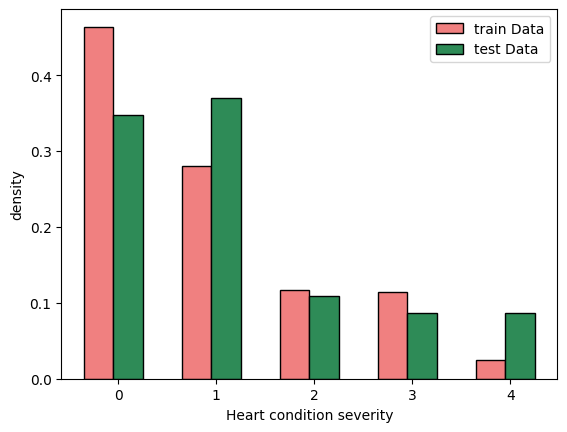

In [ ]:

fig, ax = plt.subplots()
sns.set_theme()
bins = np.arange(6)
counts_train, _ = np.histogram(y_train_nn, bins=bins)
counts_test, _ = np.histogram(y_test_nn, bins=bins)

ax.bar(bins[:-1]-0.2,counts_train/(len(y_train_nn)),alpha=1,color="lightcoral",label="train Data", edgecolor='black',width=0.3)
ax.bar(bins[:-1]+0.1,counts_test/(len(y_test_nn)),alpha=1,color="seagreen",label="test Data", edgecolor='black',width=0.3)
# ax.hist(y_test_nn,bins= np.arange(6)-0.5,density=True,alpha=0.5,color = "crimson",label="test Data")
ax.legend()
ax.set_ylabel("density")
ax.set_xlabel("Heart condition severity")



#### Binary Classifier: 3D and 2D Feature Visualization
Select three features.

<class 'pandas.core.frame.DataFrame'>
heart condition (0, 1, 2) ^
healthy heart (0, 1, 2) d


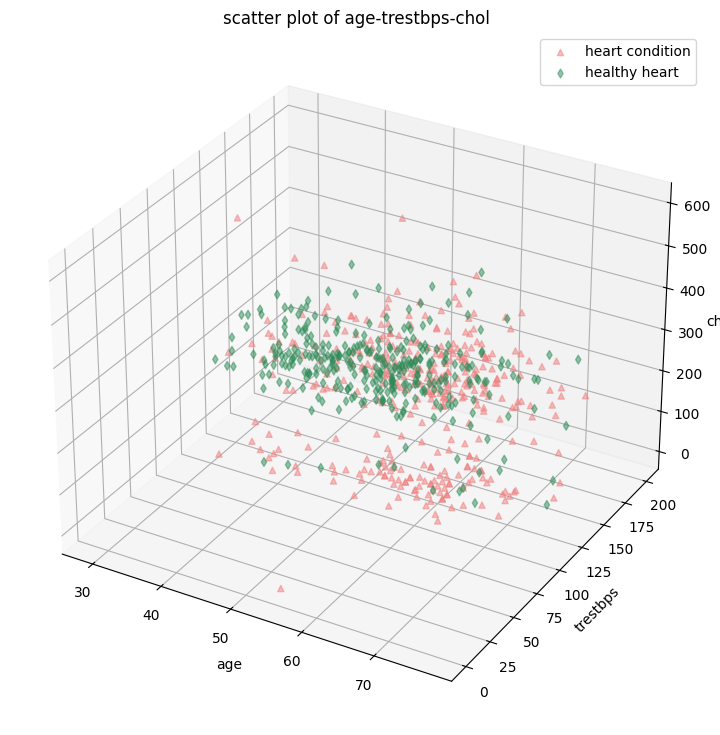

heart condition (0, 1, 3) ^
healthy heart (0, 1, 3) d


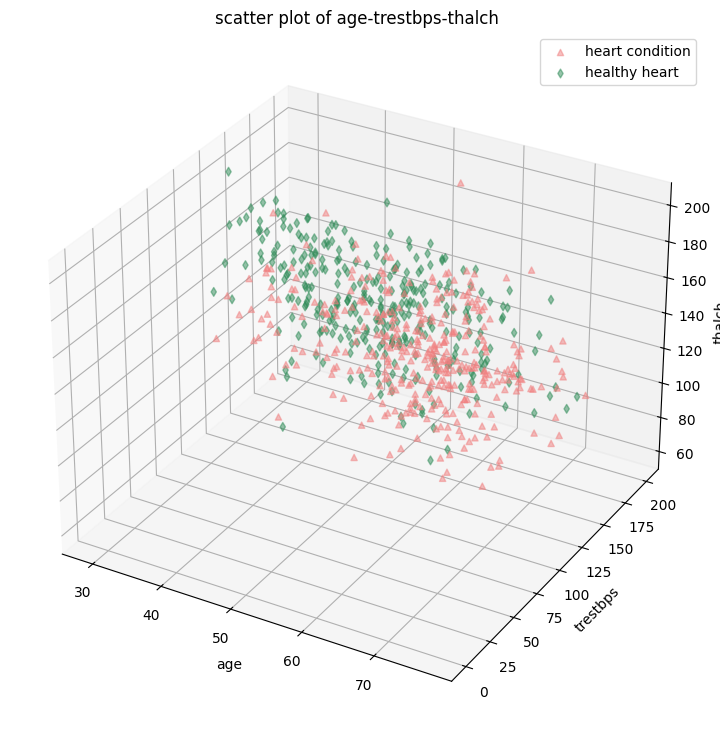

heart condition (0, 2, 3) ^
healthy heart (0, 2, 3) d


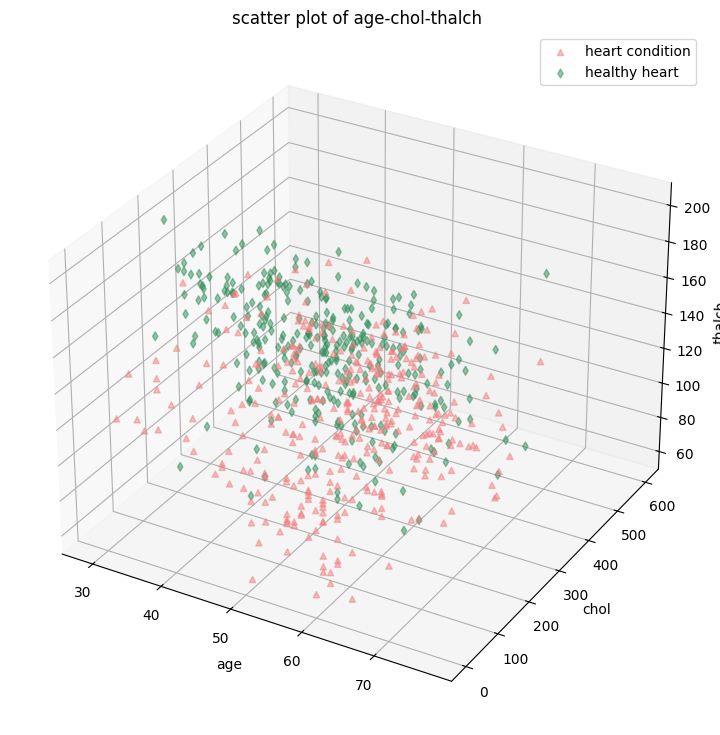

heart condition (1, 2, 3) ^
healthy heart (1, 2, 3) d


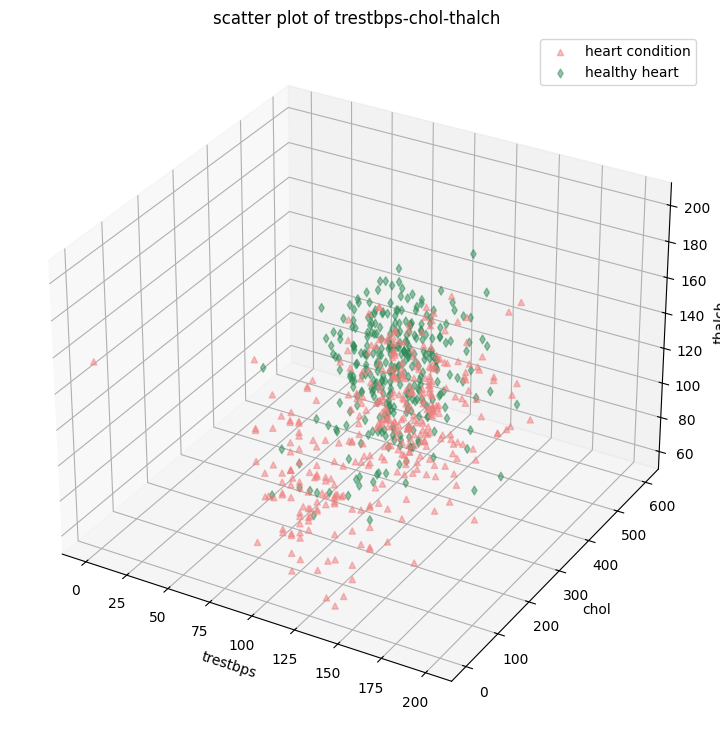

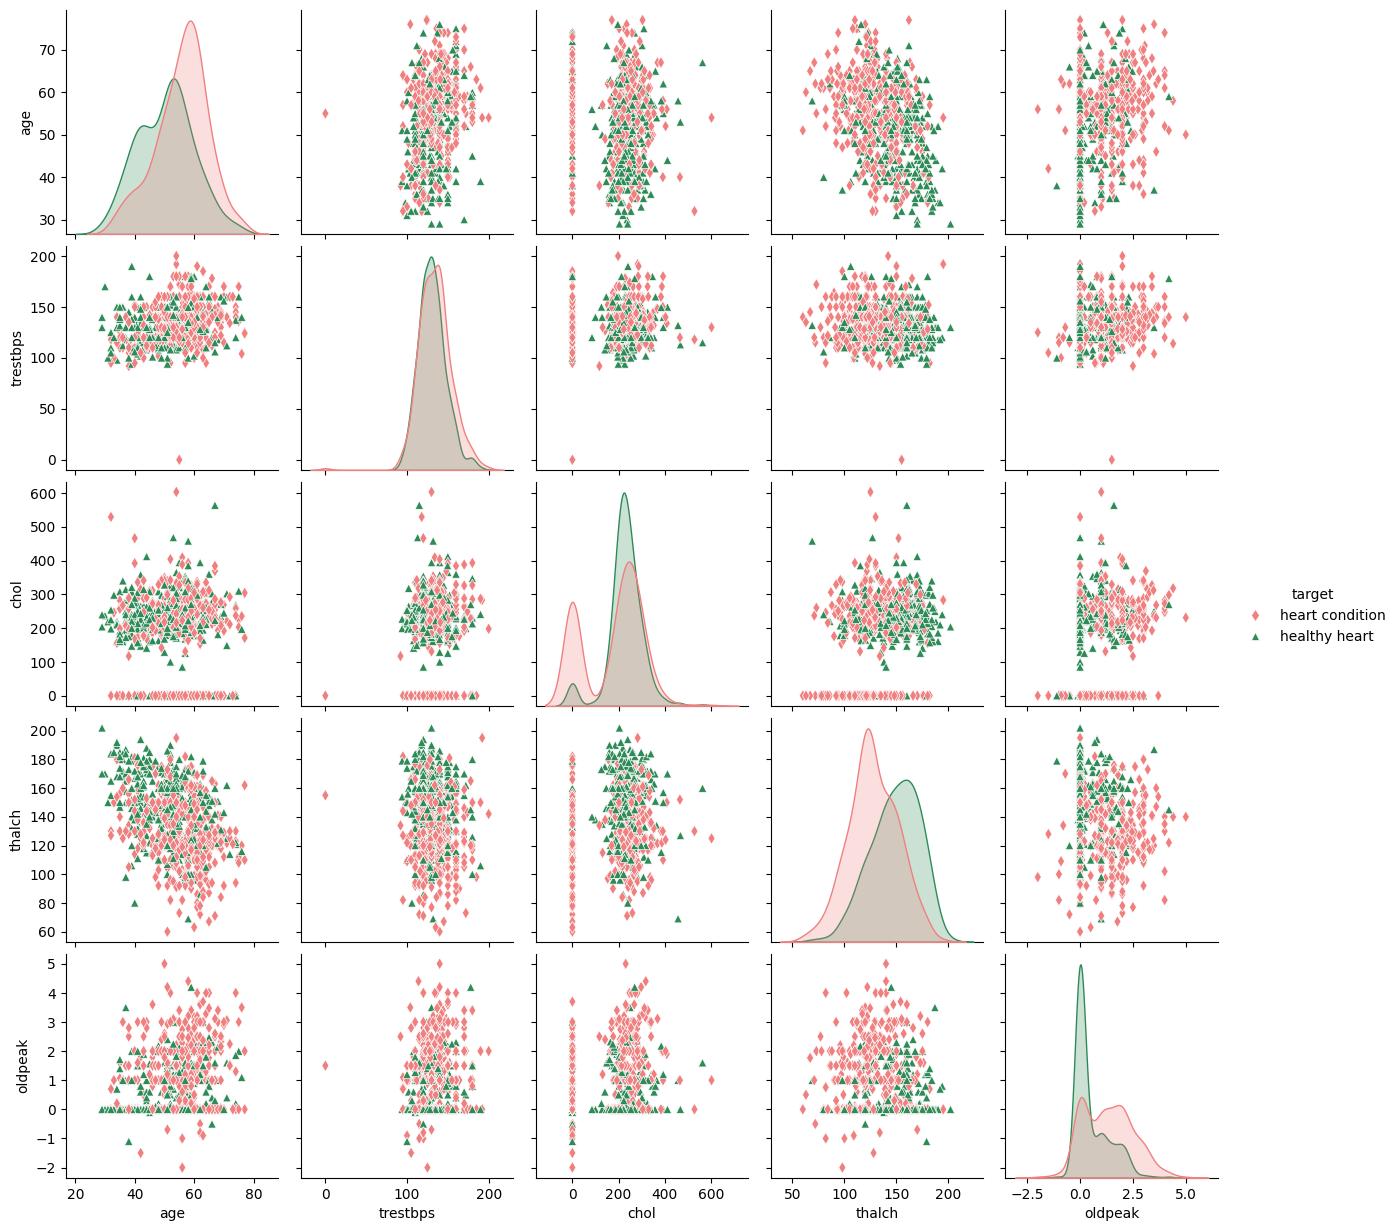

In [108]:



df_pairplot = pd.DataFrame(x_train[:,:5],columns=columns[:5])

df_pairplot["target"] = y_train_bin
print(type(df_pairplot))

combinations = list(it.combinations(range(4), 3))
for c in combinations: # c for combination
    
    fig = plt.figure(figsize=(16,9))
  
    ax = fig.add_subplot(projection='3d')
    for value ,m ,color in [["heart condition","^","lightcoral"],["healthy heart","d","seagreen"]]:
        print(value,c,m)
        df_tmp  = df_pairplot[df_pairplot["target"]==value]
        x = df_tmp[columns[c[0]]]
        y = df_tmp[columns[c[1]]]
        z = df_tmp[columns[c[2]]]
        ax.scatter(x, y, z, marker=m,c=color,label=value,alpha=0.5)
       
        ax.set_xlabel(columns[c[0]])
        ax.set_ylabel(columns[c[1]])
        ax.set_zlabel(columns[c[2]])
        ax.legend()
    ax.set_title("scatter plot of %s-%s-%s"% (columns[c[0]], columns[c[1]],columns[c[2]]))
    plt.savefig("test.pdf",format="pdf")
    plt.show()

sns.set_palette(sns.color_palette(["lightcoral","seagreen"]))
sns.pairplot(data=df_pairplot,hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])

selected_features = ["thalch", "trestbps","age"]


### Grid search for configuration
Train binary classifiers using only the three selected features as descriptive features.

For this question, we recommend taking a look at the method "cv_results" of the grid search object: https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

['thalch', 'trestbps', 'age']


C:\Users\finnv\AppData\Local\Temp\ipykernel_40484\3702457787.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trainDS["target"] = y_train_bin


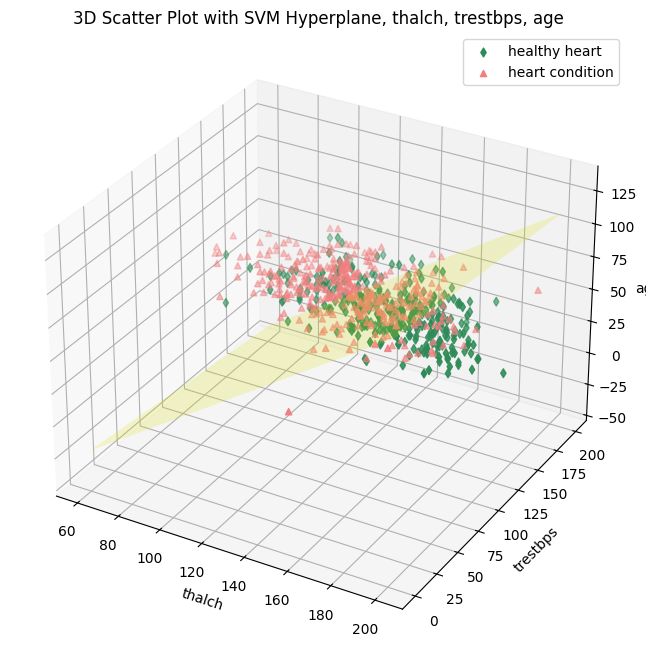

                 precision    recall  f1-score   support

  healthy heart       0.69      0.56      0.62        16
heart condition       0.79      0.87      0.83        30

       accuracy                           0.76        46
      macro avg       0.74      0.71      0.72        46
   weighted avg       0.75      0.76      0.75        46



In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

test = list(it.combinations(columns[:5], 3))
# print(test)


   
print(selected_features)
x_test_selected = df_test_feature[selected_features[:]]
x_train_selected = df_pairplot[selected_features[:]]
full_trainDS = df_pairplot[selected_features[:]]
full_trainDS["target"] = y_train_bin
svm_classifier = SVC(C=10, kernel='linear', gamma = 'auto')
svm_classifier.fit(x_train_selected, y_train_bin)
colors ={"heart condition":"lightcoral","healthy heart":"seagreen"}
markers = {"heart condition":"^","healthy heart":"d"}

plot_3d_hyperplane(svm_classifier,full_trainDS,"target",colors,markers)


predict_lin_3f = svm_classifier.predict(x_test_selected)

print(classification_report(y_test_bin, predict_lin_3f))






Fitting 5 folds for each of 15 candidates, totalling 75 fits


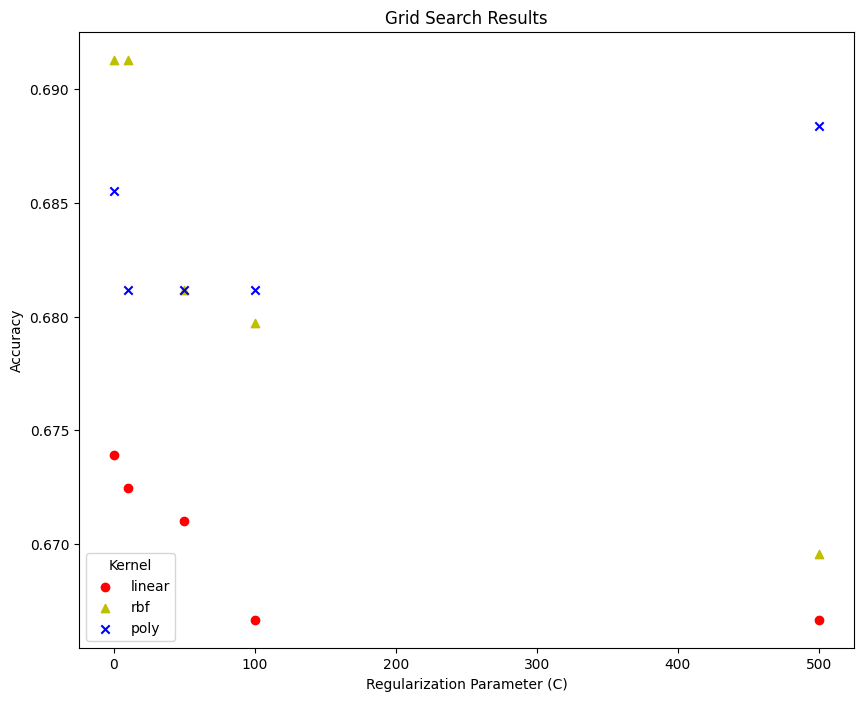

In [115]:
from sklearn.model_selection import GridSearchCV


grid_params_selected_features = {
    "C": [0.1, 10, 50, 100, 500],
    "kernel": ["linear", "rbf", "poly"],

}

grid = GridSearchCV(SVC(), grid_params_selected_features,scoring= 'accuracy', cv=5, verbose = 3,n_jobs=5)
fit = grid.fit(x_train_selected,y_train_bin)
compare_results_grid_search(grid,"grid search")


In [124]:
# print(grid.cv_results_)
best_params = grid.best_params_
# print(best_params)
best_params_kernel = pd.DataFrame()
results = pd.DataFrame(grid.cv_results_)
for kernel in results["param_kernel"].unique():
    kernel_data = results[results["param_kernel"] == kernel]
    index = kernel_data["mean_test_score"].idxmax()
    test = [kernel_data["param_C"][index], kernel_data["mean_test_score"][index]]
    print("best performing params for %s"%kernel, kernel_data["param_C"][index], kernel_data["mean_test_score"][index])
    # best_params_kernel[kernel] = test

    svm_classifier = SVC(C=kernel_data["param_C"][index], kernel=kernel)
    fit = svm_classifier.fit(x_train_selected,y_train_bin)
    predict = svm_classifier.predict(x_test_selected)
    print(kernel,":",classification_report(y_test_bin,predict))

# print(best_params_kernel)



best performing params for linear 0.1 0.6739130434782609
linear :                  precision    recall  f1-score   support

  healthy heart       0.69      0.56      0.62        16
heart condition       0.79      0.87      0.83        30

       accuracy                           0.76        46
      macro avg       0.74      0.71      0.72        46
   weighted avg       0.75      0.76      0.75        46

best performing params for rbf 0.1 0.691304347826087
rbf :                  precision    recall  f1-score   support

  healthy heart       0.64      0.44      0.52        16
heart condition       0.74      0.87      0.80        30

       accuracy                           0.72        46
      macro avg       0.69      0.65      0.66        46
   weighted avg       0.71      0.72      0.70        46

best performing params for poly 500.0 0.6884057971014492
poly :                  precision    recall  f1-score   support

  healthy heart       0.73      0.50      0.59        16
heart 

### Baseline Models
Both classifier types are trained using all features.

#### SVMs: Base Binary Classifier

                 precision    recall  f1-score   support

  healthy heart       0.88      0.94      0.91        16
heart condition       0.97      0.93      0.95        30

       accuracy                           0.93        46
      macro avg       0.92      0.94      0.93        46
   weighted avg       0.94      0.93      0.94        46



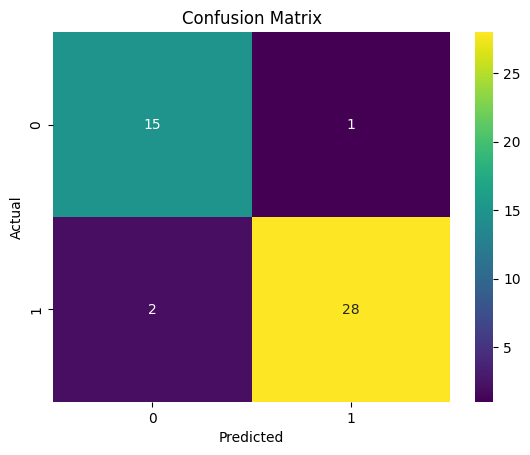

In [126]:

from sklearn.metrics import  confusion_matrix
svm_baseline = SVC(C=10, kernel="linear")
fit_base = svm_baseline.fit(x_train,y_train_bin)
predict_base = svm_baseline.predict(x_test)
print(classification_report(y_test_bin,predict_base))
conf_base =  confusion_matrix(y_test_bin,predict_base)

sns.heatmap(conf_base, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Neural Network: Base Classifier

c:\Users\finnv\envs\uni\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\finnv\envs\uni\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\finnv\envs\uni\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.35      1.00      0.52        16
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         4

    accuracy                           0.35        46
   macro avg       0.07      0.20      0.10        46
weighted avg       0.12      0.35      0.18        46



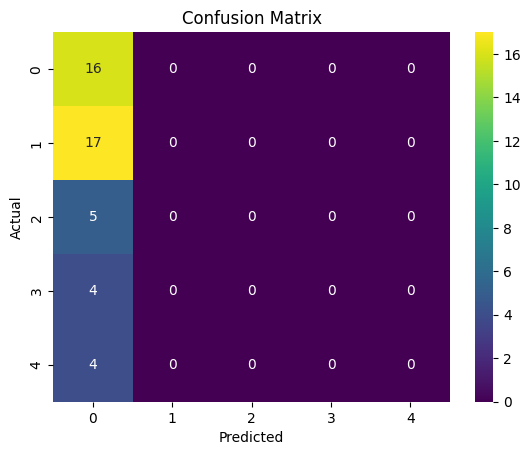

In [134]:
from sklearn.neural_network import MLPClassifier
nn_classifier = MLPClassifier(hidden_layer_sizes=(5,5,5,5,5),max_iter=5000,activation="logistic", random_state=42)
nn_fit = nn_classifier.fit(x_train, y_train_nn)
nn_pred = nn_classifier.predict(x_test)

print(classification_report(y_test_nn,nn_pred))
conf_nn =  confusion_matrix(y_test_nn,nn_pred)

sns.heatmap(conf_nn, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


### Feature Engineering

           age   trestbps        chol     thalch   oldpeak
0     7.671014  17.344681   42.428348  -0.392725  0.051612
1    -4.328986   7.344681  -13.571652  34.607275 -0.948388
2     7.671014   7.524681 -200.571652 -51.392725  0.551612
3     6.671014 -15.655319   29.428348  22.607275  0.451612
4     5.671014  -3.835319 -200.571652  -9.392725  1.051612
..         ...        ...         ...        ...       ...
685  13.671014 -26.655319   22.428348   4.607275 -0.648388
686  -0.328986  -2.655319 -200.571652  -2.392725  0.051612
687   8.671014  -4.655319    7.428348   2.607275 -0.948388
688   3.671014  27.344681 -200.571652 -39.392725  1.051612
689   2.671014  -4.655319   22.428348 -18.392725  1.051612

[690 rows x 5 columns]


KeyError: 'target'

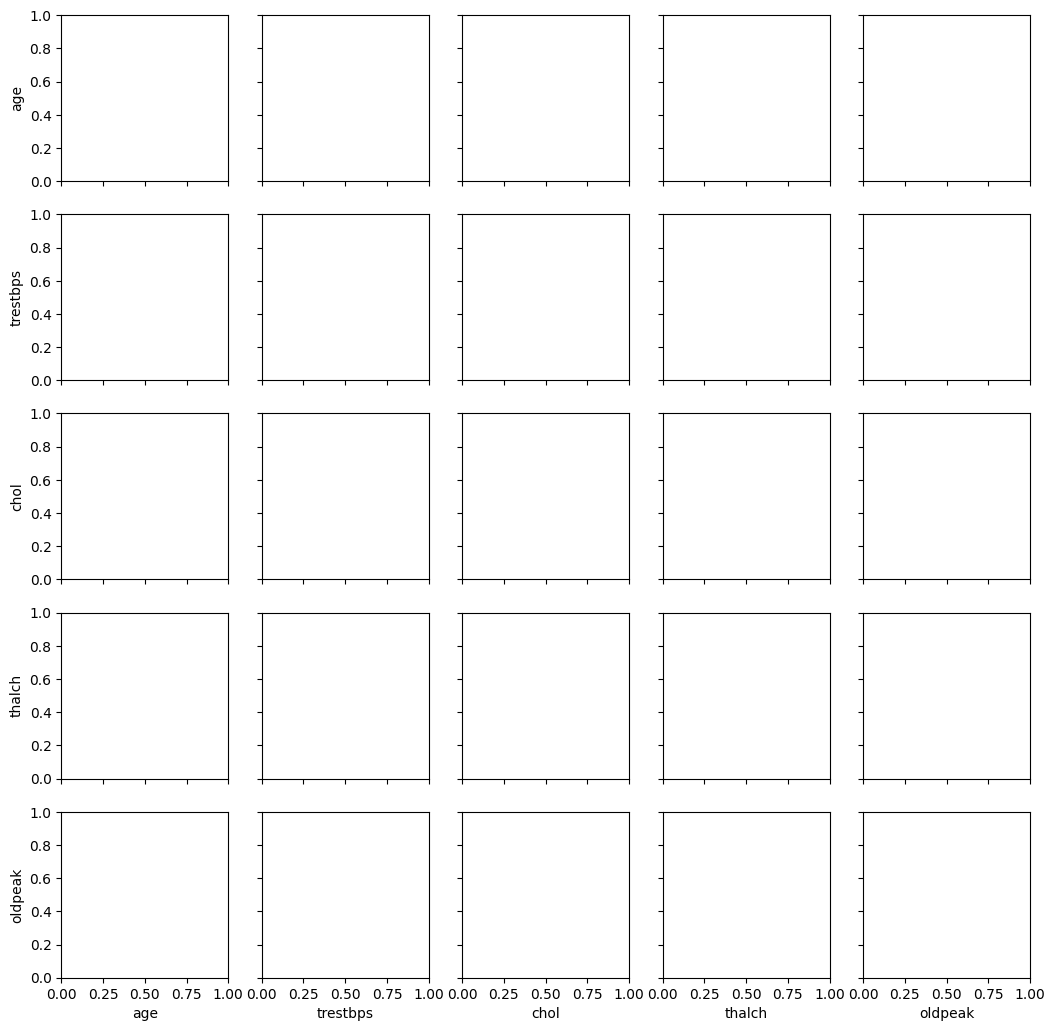

In [ ]:
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
)

def deviation_mean(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
                   target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training and test data as well as a list of features you want to transform. Function returns test and training data lifted to the higher dimension by dividing each of the passed feature names' values by the trainings data's mean."""

    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)

    ## add you code here
    training_data_transformed = training_data.copy()
    test_data_transformed = test_data.copy()
    for feature  in features_to_transform:
        mean_train = np.mean(training_data_transformed[feature])
        training_data_transformed[feature] = training_data_transformed[feature] - mean_train

        mean_test = np.mean(test_data_transformed[feature])
        test_data_transformed[feature] = test_data_transformed[feature] - mean_test

    ...
    test_data_transformed = test_data_transformed[features_to_transform]
   
    

    training_data_transformed = training_data_transformed[features_to_transform]
    
    return training_data_transformed, test_data_transformed

# test = deviation_mean(df_train,df_test,columns[:5],"num")
# print(test)
def scale_zero(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
               target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training data and test data as well as a list of features you want to transform. Function returns dataframes containing the transformed test and training data. In the transformed dataframes the values of each of the passed feature names are scaled around zero."""
    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)
    
    ## add you code here

    training_data_transformed = training_data.copy()
    test_data_transformed = test_data.copy()
    train_data_inter = StandardScaler().fit_transform(training_data[features_to_transform])
    test_data_inter = StandardScaler().fit_transform(test_data[features_to_transform])
    for i  in range(len(features_to_transform)):
        training_data_transformed[features_to_transform[i]] = train_data_inter[:,i]
        test_data_transformed[features_to_transform[i]] = test_data_inter[:,i]
    ...

    test_data_transformed = test_data_transformed[features_to_transform]

    

    training_data_transformed = training_data_transformed[features_to_transform]
    

    return training_data_transformed, test_data_transformed


def normalize_features(training_data: pd.DataFrame, test_data: pd.DataFrame, features_to_transform: list = None,
                       target_name: str = target_name) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Pass training data and test data as well as a list of features you want to transform. Function returns dataframes containing the transformed test and training data. In the transformed dataframes the values of each of the passed features are normalized according to the value's ranges."""

    if features_to_transform is None:
        features_to_transform = training_data.columns.drop(target_name)

    ## add you code here
    training_data_transformed = training_data.copy()
    test_data_transformed = test_data.copy()
    train_data_inter = MinMaxScaler().fit_transform(training_data[features_to_transform])
    test_data_inter = MinMaxScaler().fit_transform(test_data[features_to_transform])
    for i  in range(len(features_to_transform)):
        training_data_transformed[features_to_transform[i]] = train_data_inter[:,i]
        test_data_transformed[features_to_transform[i]] = test_data_inter[:,i]
    ...
    test_data_transformed = test_data_transformed[features_to_transform]
   
    

    training_data_transformed = training_data_transformed[features_to_transform]
   
    return training_data_transformed, test_data_transformed
# test = normalize_features(df_train,df_test,columns[:5],"num")


df_train_full = df_train_feature.copy()
df_train_full["target"] = df_train_str_target 
df_test_full = df_test_feature.copy()
df_test_full["target"] = df_test_str_target 
# print(deviation_mean(df_train_full,df_test_full,columns[:5],"target")[0])
test = deviation_mean(df_train_full,df_test_full,columns[:5],"target")[0]
sns.set_palette(sns.color_palette(["lightcoral","seagreen"]))
sns.pairplot(data=test,hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])
plt.show()
sns.pairplot(data=scale_zero(df_train_full,df_test_full,columns[:5],"target")[0],hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])
plt.show()
sns.pairplot(data=normalize_features(df_train_full,df_test_full,columns[:5],"target")[0],hue="target",hue_order=["heart condition","healthy heart"],markers=["^","d"])




In [170]:
x_train_scaled = normalize_features(df_train,df_test,columns[:5],"num")[0]
print(df_train["num"])
# x_train_scaled.drop("target",axis='columns')
# print(x_trained)
# x_train_scaled=x_train_scaled.to_numpy(dtype=np.float64)

0      0
1      0
2      3
3      2
4      2
      ..
685    0
686    2
687    0
688    2
689    2
Name: num, Length: 690, dtype: int64


### Neural Network Structure
First, only consider the training data. Then, in the next subtask, consider the test data as well.

In [159]:
nn_classifier = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,),max_iter=5000,activation="logistic")
nn_fit = nn_classifier.fit(x_train_scaled, y_train_nn)


print(classification_report(y_test_nn,nn_pred))
conf_nn =  confusion_matrix(y_test_nn,nn_pred)

sns.heatmap(conf_nn, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'x_train_scaled' is not defined

### Good SVM Classifier
Perform some educated trial and error to try and find a good SVM classifier.

In [ ]:
nn_pred = nn_classifier.predict(x_test)